In [1]:
import pandas as pd
import numpy as np
from collections import defaultdict

In [2]:
benchmarks = pd.read_csv('data/benchmarks.csv')
backup = {e['Model']: {
    'power': float(e['Power (Watts)']),
} for e in benchmarks.to_dict(orient='records')}

reference = pd.read_csv('data/reference.csv')
reference = {e['Model']: {
    'power': float(e['Power (Watts)']),
    'release': pd.to_datetime(e['Release']).date()
} for e in reference.to_dict(orient='records')}

In [3]:
all_triplets = defaultdict(list)

# this parameter was found by analyzing minermonitoring.com benchmarks 
def nominal_to_true_power(nominal_power):
    return nominal_power * 0.7046

for model, ref_model, hashrate, power, source in benchmarks.values:
    if ref_model not in reference:
        continue
    if power != power:
        nominal_power = reference[ref_model]['power']
        if nominal_power != nominal_power:
            continue
        power = nominal_to_true_power(nominal_power)
    efficiency = hashrate / power
    release = reference[ref_model]['release']
    all_triplets[source].append((ref_model, release, efficiency))

In [4]:
import datetime

def max_hashrate(releases, hashrates, start_date=datetime.date(2016,5,13), end_date=datetime.date(2021,3,20)):
    max_curve = np.zeros(((end_date - start_date).days))
    for release, hashrate in zip(releases, hashrates):
        offset = max(0, (release - start_date).days)
        if hashrate != hashrate:
            continue
        max_curve[offset:] = np.maximum(hashrate, max_curve[offset:])
    dates = []
    date = start_date
    delta = datetime.timedelta(days=1)
    while date < end_date:
        dates.append(date)
        date += delta
    return dates, max_curve

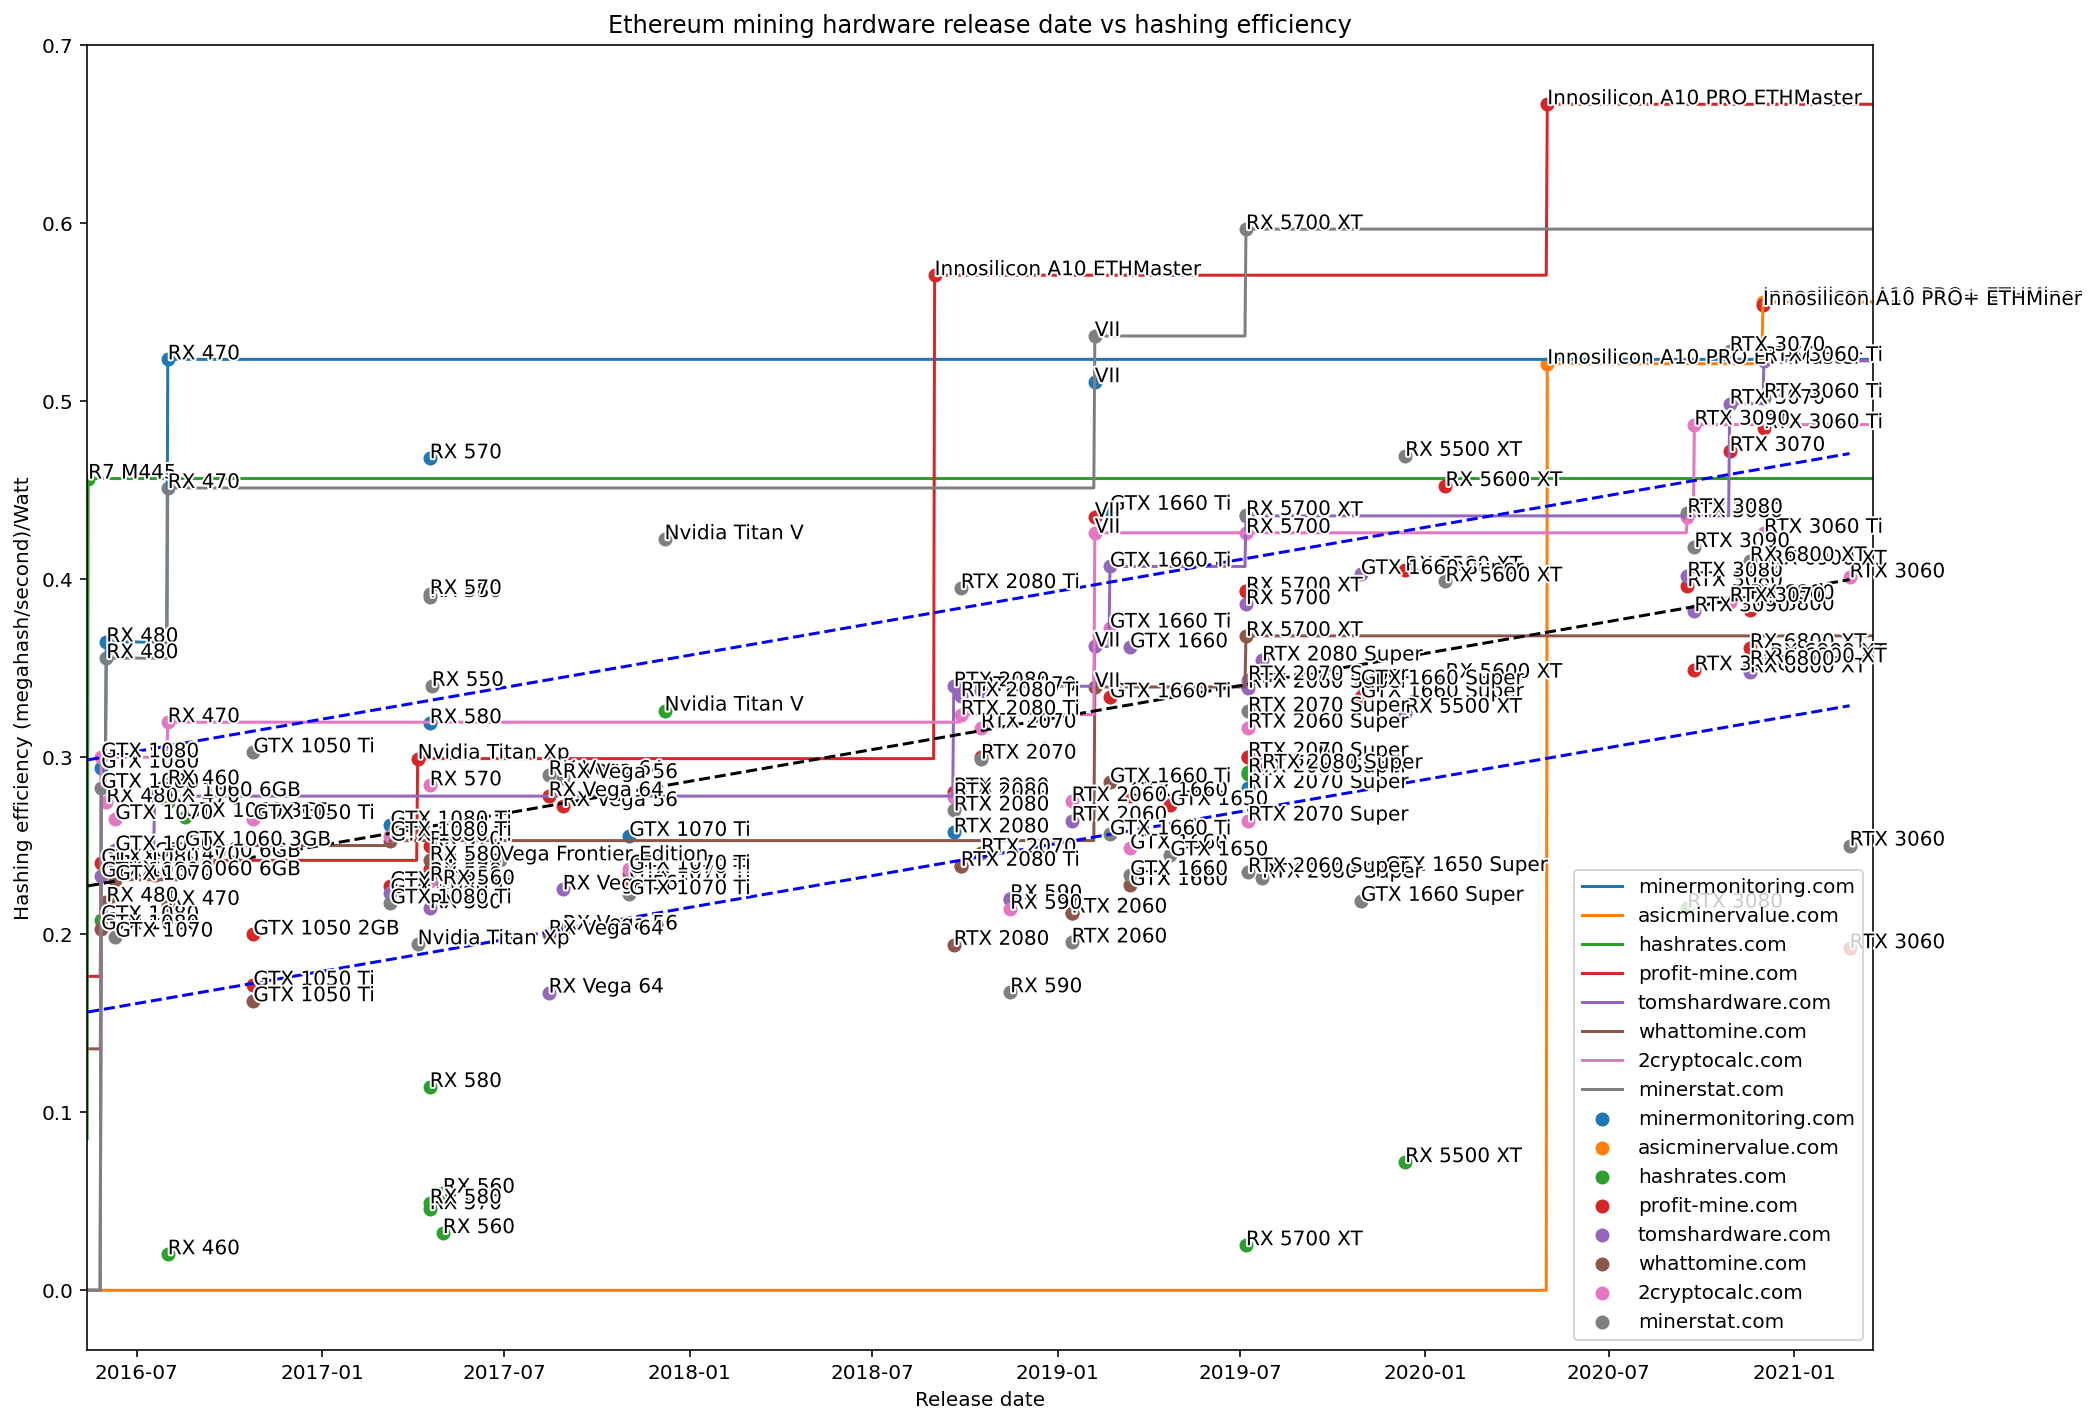

In [5]:
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
effects = [path_effects.Stroke(linewidth=2, foreground='white'), path_effects.Normal()]

start_date = datetime.date(2016,5,13)
end_date = datetime.date(2021,3,20)

plt.figure(figsize=(16,12), facecolor='white')
plt.title(f'Ethereum mining hardware release date vs hashing efficiency')

pts = []

for source, triplets in all_triplets.items():
    labels, releases, hashrates = zip(*triplets)
    plt.scatter(releases, hashrates, label=source)
    dates, max_curve = max_hashrate(releases, hashrates)
    plt.plot(dates, max_curve, label=source)
    for label, release, hashrate in triplets:
        if release < start_date or release > end_date:
            continue
        label = label.replace('GeForce ', '').replace('Radeon ', '')
        text = plt.text(release, hashrate, label)
        text.set_path_effects(effects)
        pts.append((release, hashrate))
        
def date_to_timestamp(e):
    return datetime.datetime.timestamp(datetime.datetime(e.year, e.month, e.day))

def timestamp_to_date(e):
    return datetime.datetime.fromtimestamp(e).date()

xs,ys = zip(*pts)
xs = [date_to_timestamp(e) for e in xs]
z = np.polyfit(xs, ys, 1)
p = np.poly1d(z)
ends = [min(xs), max(xs)]
plt.plot([timestamp_to_date(e) for e in ends], p(ends), 'k--')

mae = np.mean(np.abs(ys - p(xs)))
plt.plot([timestamp_to_date(e) for e in ends], p(ends)+mae, 'b--')
plt.plot([timestamp_to_date(e) for e in ends], p(ends)-mae, 'b--')

plt.legend()
plt.xlabel('Release date')
plt.ylabel('Hashing efficiency (megahash/second)/Watt')
plt.xlim((start_date, end_date))
plt.show()

In [6]:
z, mae

(array([ 1.13978483e-09, -1.44042555e+00]), 0.07086620720601468)